In [10]:
#from transformer import *
import torch
from plotting import *
import matplotlib.pyplot as plt
#import os

In [11]:
if torch.cuda.is_available():
    device = torch.device(type='cuda', index=1)
else:
    device = torch.device('cpu')
print("device is ", device)

device is  cuda:1


In [12]:
import pandas as pd
import torch
from torch import nn, Tensor
from torch.utils.data import dataset, DataLoader, Subset
from torchvision import transforms

from PIL import Image

class TrajDataset(dataset.Dataset):

    to_tensor = transforms.ToTensor()
    # cols = ["track_id", "xmin", "ymin", "xmax", "ymax", "frame", "lost", "occluded", "generated", "label"]

    def __init__(self, data_folders, n_prev, n_next, img_step, n_trajs, device=None):
        
        self.data_folders = data_folders
        self.n_prev = n_prev
        self.n_next = n_next
        self.img_step = img_step
        self.n_trajs = n_trajs

        self.src = Tensor()
        self.coords = Tensor()
        self.tgt = Tensor()
        self.process_data()
        self.device = device
        self.block_size = int(data_folders[0].split("_")[-1])
        
    def process_data(self):
        src = []
        coords = []
        tgt = []
        
        for folder, (first_traj, last_traj) in zip(self.data_folders, self.n_trajs):
            raw_data = pd.read_csv(folder + "/annotations_" + str(self.img_step) + ".txt", sep=" ")
            #print(raw_data)
            #raw_data = raw_data[raw_data.index % self.img_step == 0]

            track_ids = raw_data["track_id"].unique()[first_traj:last_traj]

            for track_id in track_ids:
                print("opening track " + str(track_id) + " from " + folder)
                traj = raw_data[raw_data["track_id"] == track_id]  # get all positions of track
                memo = {}
                for i in range(len(traj) - self.n_next - self.n_prev):
                    # n_prev images used to predict
                    x = self.get_n_images_after_i(folder, traj, self.n_prev, i, memo)
                    src.append(x)
                    # images that should be predicted
                    c = traj.iloc[i: i + self.n_prev][["x", "y"]]
                    coords.append(Tensor(c.values))
                    # bounding boxes inside predicted images
                    y = traj.iloc[i + self.n_prev: i + self.n_prev + self.n_next][["x", "y"]]  # recuperer le grand truth à prédire
                    tgt.append(Tensor(y.values)) # add to ground truth dataset

        self.src = torch.stack(src, dim=0).to(device=device)
        self.coords = self.normalize_coords(torch.stack(coords, dim=0)).to(device=device)
        self.tgt = self.normalize_coords(torch.stack(tgt, dim=0)).to(device=device)

    def normalize_img(self, img):
        return img / img.norm(p=2)

    def normalize_coords(self, tgt):
        return tgt / self.get_image_size()[0]

    def get_n_images_after_i(self, folder, traj, n, i, memo):
        X = []
        for ind, pos in traj.iloc[i: i+n,:].iterrows():
            track_id = pos["track_id"]
            frame = pos["frame"]
            path = f"{folder}/{track_id:03d}_{frame:05d}.jpg"
            if path in memo:
                img = memo[path]
            else:
                img = Image.open(f"{folder}/{track_id:03d}_{frame:05d}.jpg")
                memo[path] = img
            img_tensor = self.to_tensor(img)
            X.append(self.normalize_img(img_tensor))
        return torch.cat(X)

    def __getitem__(self, item):
        return {
            'src' : self.src[item],
            'coords' : self.coords[item],
            'tgt' : self.tgt[item]
        }

    def __len__(self):
        return len(self.src)

    def get_image_size(self):
        return self.src[0].size()[1:]
    

    def get_dataset_infos(self):
        return {"image_size":self.get_image_size(),
                "n_prev": self.n_prev,
                "n_next": self.n_next,
                "block_size": self.block_size
               }


In [14]:
size = "64_64_8"
folders = ["bookstore/video0/"]
n_trajs = [(0,2)]
data_folders = ["datasets/" + folder + size for folder in folders]

train_prop = 0.9

n_prev=8
n_next=4
img_step = 20

full_dataset = TrajDataset(data_folders, n_prev=n_prev, n_next=n_next, img_step=img_step, n_trajs=n_trajs, device=device)
dataset_infos = full_dataset.get_dataset_infos()

def train_val_split(dataset, prop):
    n = len(dataset)
    n_train = int((n * prop) + 1)
    n_val = n - n_train
    rand = torch.randperm(n)
    train_dataset = Subset(dataset, rand[:n_train])
    val_dataset = Subset(dataset, rand[n_train:])
    return train_dataset, val_dataset

train_dataset, val_dataset = train_val_split(full_dataset, 0.8)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=20, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

opening track 0 from datasets/bookstore/video0/64_64_8
opening track 1 from datasets/bookstore/video0/64_64_8
45
10


In [15]:
print(len(full_dataset))
print(len(train_dataset))
print(len(val_dataset))

55
45
10


In [16]:
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import Transformer, TransformerEncoder, TransformerEncoderLayer, TransformerDecoder, TransformerDecoderLayer
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD, RMSprop

from datetime import datetime

from einops import rearrange
from einops.layers.torch import Rearrange

from plotting import *


def pair(t):
    return t if isinstance(t, tuple) else (t, t)


def posemb_sincos_3d(patches, temperature=10000, dtype=torch.float32, device=device):
    (_, f, h, w, dim) , dtype = patches.shape, patches.dtype
    
    x, y, z = torch.meshgrid(
        torch.arange(f, device=device),
        torch.arange(h, device=device),
        torch.arange(w, device=device),
        indexing='ij')

    fourier_dim = dim // 6

    omega = torch.arange(fourier_dim, device=device) / (fourier_dim - 1)
    omega = 1. / (temperature ** omega)

    z = z.flatten()[:, None] * omega[None, :]
    y = y.flatten()[:, None] * omega[None, :]
    x = x.flatten()[:, None] * omega[None, :]

    pe = torch.cat((x.sin(), x.cos(), y.sin(), y.cos(), z.sin(), z.cos()), dim=1)

    pe = F.pad(pe, (0, dim - (fourier_dim * 6)))  # pad if feature dimension not cleanly divisible by 6
    return pe.type(dtype)


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, out_dim=None):
        super().__init__()
        self.net = nn.Sequential(
            # nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, out_dim if out_dim else dim),
        )

    def forward(self, x):
        x = torch.flatten(x, 1)
        return self.net(x)


class TrajVit(nn.Module):

    def __init__(self, d_model, dataset_infos, image_patch_size=(8, 8), frame_patch_size=4, n_heads=8,
                 n_layers=6, mlp_dim=512, channels=1, batch_first=True):
        super(TrajVit, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.model_type = 'TrajVit'
        self.device = device
        self.dataset_infos = dataset_infos
        
        n_next = dataset_infos["n_next"]
        
        # images and patches infos
        frames = dataset_infos["n_prev"]
        image_size = dataset_infos["image_size"]
        self.image_size = image_size
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(image_patch_size)
        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        assert frames % frame_patch_size == 0, 'Frames must be divisible by the frame patch size'


        num_patches = (image_height // patch_height) * (image_width // patch_width) * (frames // frame_patch_size)
        patch_dim = channels * patch_height * patch_width * frame_patch_size
        
        num_patches_per_image = image_height*image_width//(patch_height*patch_width)
        self.num_patches_per_image = num_patches_per_image
        self.sos = torch.ones((d_model), device=device).unsqueeze(0)
        
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b (f pf) (h p1) (w p2) -> b f h w (p1 p2 pf)', p1=patch_height, p2=patch_width,
                      pf=frame_patch_size),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, d_model),
            nn.LayerNorm(d_model),
        ).to(self.device)
        
        
        self.coord_to_embedding_layer = nn.Linear(n_next*2, n_next * d_model, device=device)

        # normalization
        self.normalisation = nn.Identity(device=device)
        
        self.coord_to_img_layer = nn.Linear(n_next*2, n_next*image_height*image_width, device=device)
        
        # encoder
        #encoder_layer = nn.TransformerEncoderLayer(d_model, n_heads, batch_first=batch_first, device=device)
        #self.encoder = TransformerEncoder(encoder_layer, n_layers)
        # decoder
        #decoder_layer = nn.TransformerDecoderLayer(d_model, n_heads, batch_first=batch_first, device=device)
        #self.decoder = TransformerDecoder(decoder_layer, n_layers)

        self.transformer = nn.Transformer(d_model, n_heads, n_layers, batch_first = True, device=device)
        
        # MLP for regression
        num_patch_future = (image_height // patch_height) * (image_width // patch_width) * max((dataset_infos['n_next'] // frame_patch_size), 1)
        input_mlp = n_next * d_model
        print((image_height // patch_height) * (image_width // patch_width))
        print((dataset_infos['n_next'] // frame_patch_size), dataset_infos['n_next'], frame_patch_size)
        print("n_next:", dataset_infos['n_next'])
        print("num patches fut", num_patch_future)
        print("input mlp:", input_mlp)
        self.mlp = FeedForward(input_mlp, mlp_dim, n_next * 2).to(device=device)
        return
    
    def coord_to_img(self, tgt):
        x = torch.flatten(tgt, 1)
        x = self.coord_to_img_layer(x)
        return x.view(-1, self.dataset_infos["n_next"], *self.image_size)
    
    def coord_to_embedding(self, tgt):
        x = torch.flatten(tgt, 1)
        x = self.coord_to_embedding_layer(x)
        return x.view(-1, self.dataset_infos["n_next"], self.d_model)
    
    def train_forward(self, src, tgt):
        (batch_size, n_prev, h, w) , dtype = src.size(), src.dtype
        batch_size2, n_next, coords = tgt.shape
        assert batch_size == batch_size2
        
        #src = src.to(self.device)
        #tgt = tgt.to(self.device)
        
        src_e = self.to_patch_embedding(src)
        src_pe = posemb_sincos_3d(src_e, device=self.device)
        src_e = rearrange(src_e, 'b ... d -> b (...) d') + src_pe
        
        """
        tgt_img = self.coord_to_img(tgt)
        
        tgt_e = self.to_patch_embedding(tgt_img).to(self.device)
        tgt_pe = posemb_sincos_3d(tgt_e)
        tgt_e = rearrange(tgt_e, 'b ... d -> b (...) d') + tgt_pe
        """
        
        tgt_e = self.coord_to_embedding(tgt)
        
        src_mask = Transformer.generate_square_subsequent_mask(src_e.size()[1]).to(device=self.device).t()
        tgt_mask = Transformer.generate_square_subsequent_mask(tgt_e.size()[1]).to(device=self.device)
        
        x = self.transformer(src_e, tgt_e, src_mask, tgt_mask)
        
        """
        x = self.encoder(src_e)

        #tgt_mask = torch.triu(torch.full((itm_e.size()[1], itm_e.size()[1]), float('-inf'))).to(device=self.device)
        #tgt_mask = torch.ones((x.size()[1], x.size()[1])).to(device=self.device)
        tgt_mask = Transformer.generate_square_subsequent_mask(tgt_e.size()[1]).to(device=self.device)
        
        x = self.decoder(tgt_e, x, tgt_mask=tgt_mask)
        """
        #print("x mlp in teacher forcing: ", x.size())
        x = self.mlp(x)
        x = x.view((batch_size, -1, 2))
        return x
    
    def test_forward(self, src):
        (batch_size, _, h, w), dtype = src.size(), src.dtype
        n_next = self.dataset_infos['n_next']
        sos = self.sos.repeat((batch_size, 1, 1))
        
        #src = src.to(self.device)
        
        src_e = self.to_patch_embedding(src)
        src_pe = posemb_sincos_3d(src_e, device=device)
        src_e = rearrange(src_e, 'b ... d -> b (...) d') + src_pe
        
        tgt_e = sos
        #print("tgt_e size ", tgt_e.size())
        outputs = []
        for _ in range(n_next):
            #print("tgt_e size auto reg: ", tgt_e.size())
            pred = self.transformer(src_e, tgt_e)
            outputs.append(pred)
            tgt_e = pred #torch.cat(outputs, dim=1)
        x = torch.cat(outputs, dim=1)
        x = self.mlp(x)
        x = x.view((batch_size, -1, 2))
        return x

    def forward(self, src, tgt=None):
        if tgt is None:
            return self.test_forward(src)
        return self.train_forward(src, tgt)
    
    
    def save_state_dict(self):
        now = datetime.now()
        now_str = f"{now.year}{now.month:02d}{now.day:02d}_{now.hour}{now.minute}{now.second}"
        filename = f"models/{now_str}_{self.d_model}_{self.n_heads}_{self.n_layers}_{self.dataset_infos['image_size'][0]}_{self.dataset_infos['n_prev']}_{self.dataset_infos['n_next']}_{self.dataset_infos['block_size']}.pt"
        torch.save(self, filename)
        return
    
    def save(self):
        now = datetime.now()
        now_str = f"{now.year}{now.month:02d}{now.day:02d}_{now.hour}{now.minute}{now.second}"
        filename = f"models/{now_str}_{self.d_model}_{self.n_heads}_{self.n_layers}_{self.dataset_infos['image_size'][0]}_{self.dataset_infos['n_prev']}_{self.dataset_infos['n_next']}_{self.dataset_infos['block_size']}.pt"
        scripted = torch.jit.script(self) # Export to TorchScript
        scripted.save(filename)
        return
    
    @staticmethod
    def load_state_dict(filename):
        elems = [int(e) for e in filename[:-3].split("_")[2:]]
        dataset_infos = {key: val for key,val in zip(['image_size', 'n_prev', 'n_next', 'block_size'] , elems[-4:])}
        print(dataset_infos)
        print(len(elems[:-4]))
        model = TrajVit(*elems[:-4], dataset_infos = dataset_infos)
        model.load_state_dict(torch.load(filename))
        return model
    
    @staticmethod
    def load(filename):
        return torch.jit.load(filename)

In [17]:
#m = TrajVit(512, dataset_infos)
#m.save()

In [18]:
#m2 = TrajVit.load("models/20230503_17959_512_8_6_64_8_4_8.pt")
#m2.dataset_infos

In [19]:
model = TrajVit(256, dataset_infos, image_patch_size=(8, 8), frame_patch_size=4)
optim = SGD(params=model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
lrs = []

criterion = nn.MSELoss()

loss_evol = []
loss_evol_val = []
n_epochs = 10000
# Should add epochs
do_validation = True
for epoch in range(n_epochs):
    optim.zero_grad()
    if epoch % 100 == 0: print("starting epoch: ", epoch)
    epoch_loss = []
    
    for id_b, batch in enumerate(train_loader):
        model.train()
        src = batch['src'].to(device=device)
        tgt = batch['tgt'].to(device=device)
        if epoch % 1 == 0:
            pred = model(src, tgt)
        else:
            pred = model(src)
        #print(tgt[0], "\n", pred[0])
        loss = torch.sqrt(criterion(pred, tgt))
        loss.backward()
        optim.step()
        #print(loss.item())
        epoch_loss.append(loss.item())

        lrs.append(scheduler.get_last_lr())
    loss_evol.append(epoch_loss)
    if epoch % 5 == 0:
        scheduler.step()

    if do_validation:
        model.eval()
        with torch.no_grad():
            sum_loss_val = 0
            for id_b_val, val_batch in enumerate(val_loader):
                src = val_batch['src'].to(device=device)
                #itm = batch['intermediate'].to(device=device)
                tgt = val_batch['tgt'].to(device=device)
                pred = model(src)
                #print(pred.size())
                loss = criterion(pred, tgt)
                #print(loss.item())
                sum_loss_val += loss.item()
            loss_evol_val.append(sum_loss_val/len(val_loader))


64
1 4 4
n_next: 4
num patches fut 64
input mlp: 1024
starting epoch:  0
starting epoch:  100
starting epoch:  200
starting epoch:  300
starting epoch:  400
starting epoch:  500
starting epoch:  600
starting epoch:  700
starting epoch:  800
starting epoch:  900
starting epoch:  1000
starting epoch:  1100
starting epoch:  1200
starting epoch:  1300
starting epoch:  1400
starting epoch:  1500
starting epoch:  1600
starting epoch:  1700
starting epoch:  1800
starting epoch:  1900
starting epoch:  2000
starting epoch:  2100
starting epoch:  2200
starting epoch:  2300
starting epoch:  2400
starting epoch:  2500
starting epoch:  2600
starting epoch:  2700
starting epoch:  2800
starting epoch:  2900
starting epoch:  3000
starting epoch:  3100
starting epoch:  3200
starting epoch:  3300
starting epoch:  3400
starting epoch:  3500
starting epoch:  3600
starting epoch:  3700
starting epoch:  3800
starting epoch:  3900
starting epoch:  4000
starting epoch:  4100
starting epoch:  4200
starting epo

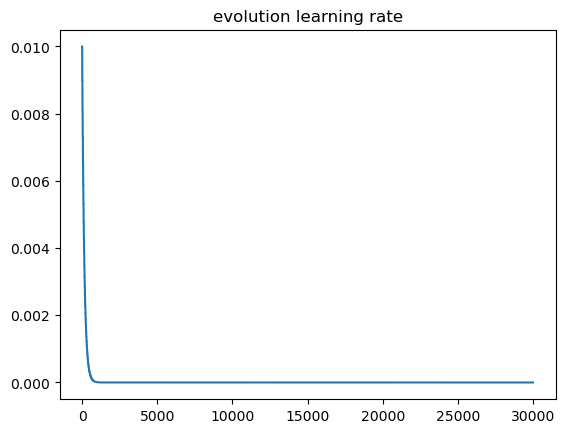

len flat:  30000


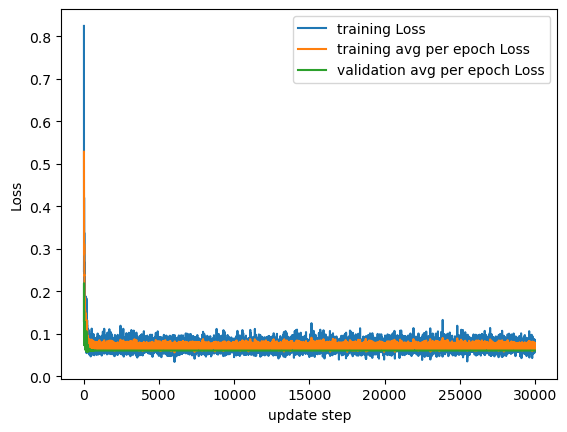

In [20]:
plt.plot(list(range(len(lrs))), lrs)
plt.title("evolution learning rate")

plt.show()

if not do_validation:
    plot_losses(loss_evol)
else:
    plot_losses(loss_evol, loss_evol_val)

tensor([[[0.6625, 0.6576],
         [0.7255, 0.6678],
         [0.6383, 0.6160],
         [0.7580, 0.6344]]])


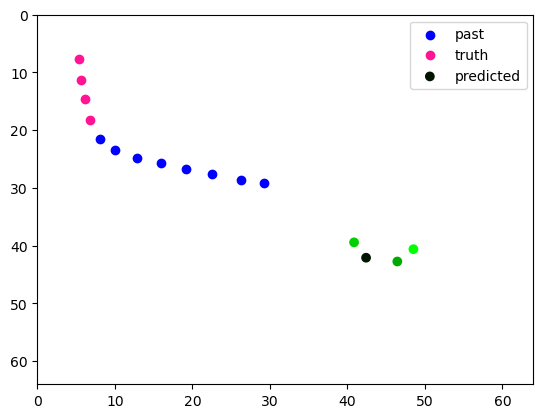

tensor([[[0.6822, 0.6372],
         [0.7561, 0.6485],
         [0.6465, 0.5929],
         [0.7658, 0.6047]]])


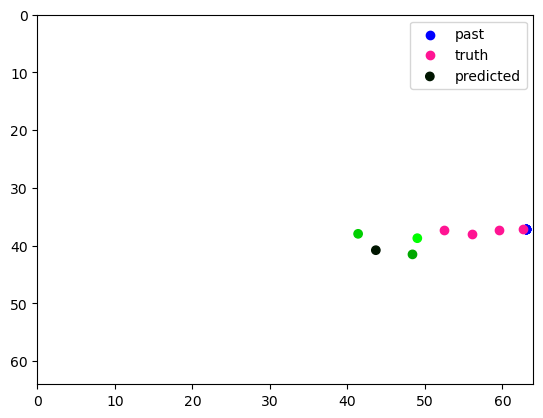

tensor([[[0.6711, 0.6330],
         [0.7418, 0.6566],
         [0.6372, 0.6055],
         [0.7563, 0.6146]]])


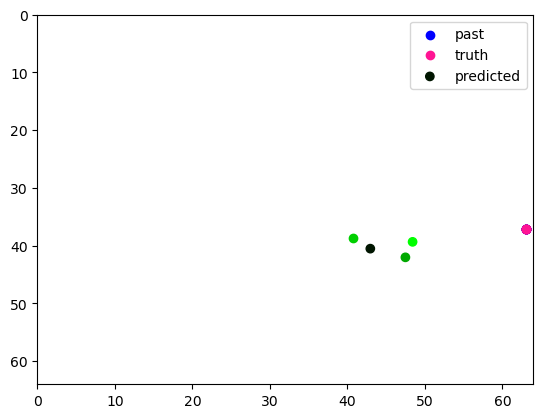

tensor([[[0.6764, 0.6304],
         [0.7463, 0.6511],
         [0.6408, 0.5923],
         [0.7610, 0.6031]]])


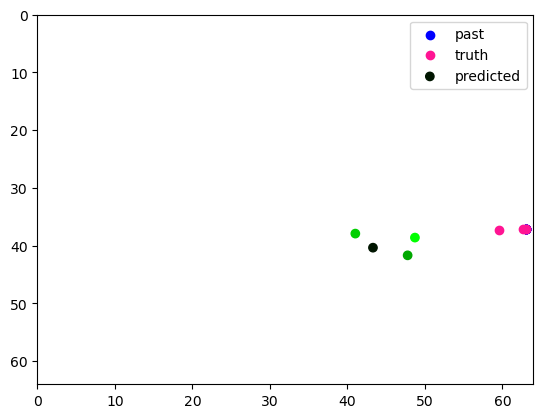

tensor([[[0.6582, 0.6478],
         [0.7316, 0.6649],
         [0.6210, 0.6158],
         [0.7480, 0.6289]]])


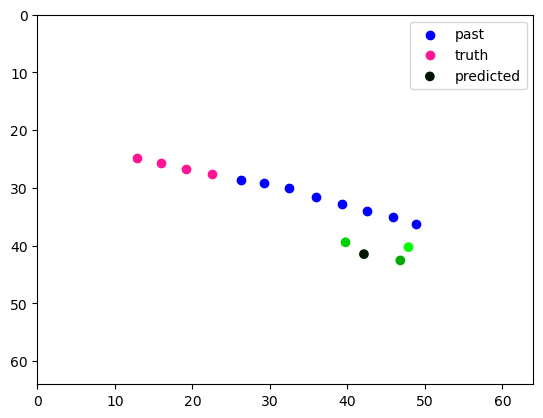

tensor([[[0.6620, 0.6579],
         [0.7263, 0.6726],
         [0.6309, 0.6228],
         [0.7557, 0.6380]]])


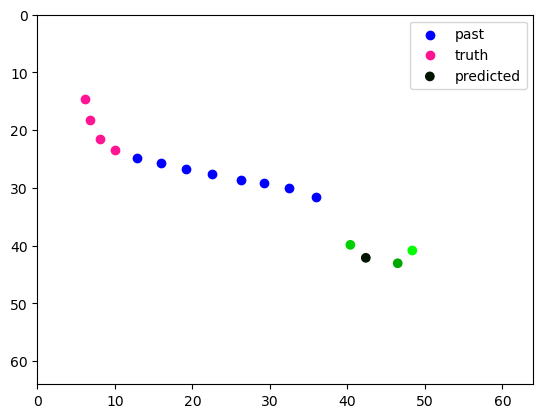

tensor([[[0.6604, 0.6538],
         [0.7324, 0.6751],
         [0.6420, 0.6252],
         [0.7581, 0.6314]]])


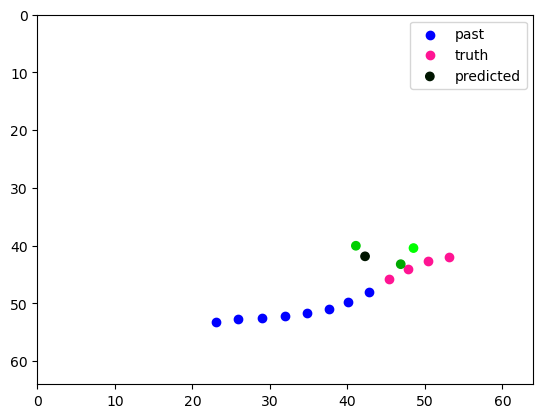

tensor([[[0.6665, 0.6543],
         [0.7379, 0.6808],
         [0.6417, 0.6263],
         [0.7569, 0.6450]]])


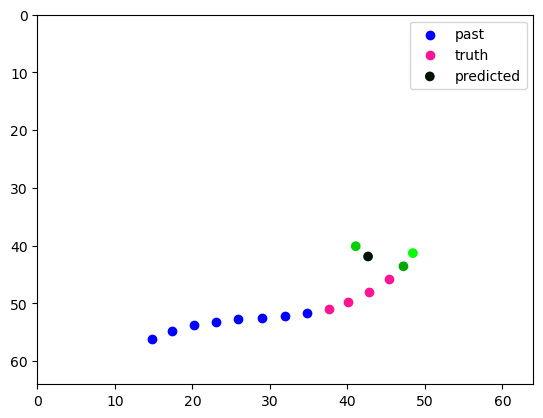

tensor([[[0.6621, 0.6536],
         [0.7371, 0.6717],
         [0.6248, 0.6196],
         [0.7541, 0.6350]]])


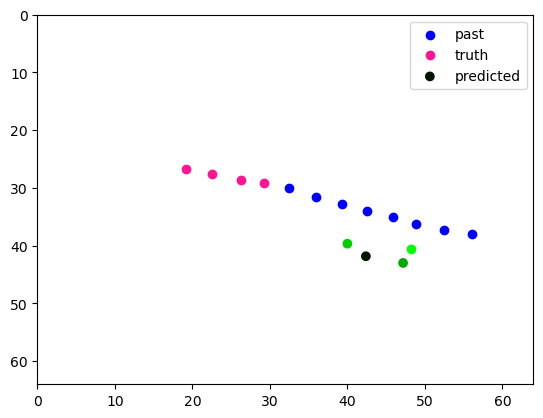

In [21]:
colors = ['#001500', '#00A800', '#00CF00', '#00FF00', '#009900', '#009900', '#009900', '#009900']
def plot_traj(past, truth, fut):
    fut = fut.t().cpu().detach().numpy()
    #print(fut)
    #reference_image = data_folders[0] + "/reference.gif"
    #image = plt.imread(reference_image)
    fig, ax = plt.subplots()
    #ax.imshow(image)
    plt.xlim(left=0, right=64)
    plt.ylim(bottom=64, top=0)
    ax.scatter(past.t()[0]*64, past.t()[1]*64, color="blue", label="past")
    ax.scatter(truth.t()[0]*64, truth.t()[1]*64, color="deeppink", label="truth")
    ax.scatter(fut[0]*64, fut[1]*64, color=colors[:len(fut[0])], label="predicted")
    ax.legend()
    plt.show()

plot_dataset = train_dataset
    
for i in range(0, 45, 5):
    model.eval()
    with torch.no_grad():
        src = plot_dataset[i:i+1]['src']
        coords = plot_dataset[i:i+1]['coords'].detach().cpu()
        tgt = plot_dataset[i:i+1]['tgt'].detach().cpu()
        future = model(src).detach().cpu()
        print(future)

    for past, truth, fut in zip(coords, tgt, future):
        plot_traj(past, truth, fut)

In [ ]:
reference_image = data_folder + "/reference.gif"
image = plt.imread(reference_image)
fig, ax = plt.subplots()
ax.imshow(image)

src = train_dataset[3:4]['src']
tgt = train_dataset[3:4]['tgt']
print("src", src.size())
print("tgt", tgt.size())
model.eval()
with torch.no_grad():
    future = model(src)
    print(future)


past = src
x = [x1, x2]
y = [y1, y2]
print(x, y)

ax.scatter(annot.x[:8], annot.y[:8], color="orange", label="before")
ax.scatter(annot.x[8:10], annot.y[8:10], color="red", label="Truth")
ax.scatter(x, y, color="blue", label="Pred")
ax.legend()
